# igv variant classifier

In [2]:
from fastai.vision import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# from PIL import Image

orignal igv screen shot: 1910x1756, 301 base pairs.  
processed image: 800x200, rectangular shape  
network input image: 750x200, i hope this provide image augmentation, crop from top.

some updates/improvement on this:

* during my first shot trial, I simply generated the igv screen shots as training images. There are quite a few shortcomings/ caveats in the image. For example,
      1) the top pane of the igv has the coordinates and a chromosome cytoband model. This should not have any useful information in determining if a variant is real or not.
      2) the left pane of the igv shows the bam file name, this should not have any useful graphic information in dtermining if a variant is real or not either.
      3) currently, images are 500x425 pixels. the resolution seems way too high. therotically for each base, we only need one pixel value. we take a screenshot for 300 base pairs. so set the width to be close to 300 and make the read width to be roughly one pixel. this will save lots of computations.
So I decided to crop out those part of the image.
* I turned off all the image transformations. It does not make sense to random rotate the image, cropping, zooming, warping, vertically flipping. I would like to keep the variant position in the centre of the image. horizontally flipping makes sense since the image should still support the same variants.
* there are some issues with the negative training images. previously, I just random pick some of the positions in the genome, which does not have a variant reported by GIAB project. But some of positions may have insufficient coverage or there is variant right next to the position in question. Also these negative samples are mostly too easy. I should come up with ways to include more challenging negative training set.
* it looks like fastai data block api can actually take rectangular images. will experiment if it works since this is especially relevant to igv screen shots. 


## View data

In [129]:
doc(get_transforms)

In [110]:
xtra_tfm = [crop(size=(200, 750), row_pct=0., col_pct=np.random.rand())] 

I need a special set transformation. I don't want the image always center-cropped. I don't know how to achieve this yet.

In [115]:
path = Path('/projects/da_workspace/szspace/data/snapshots')
classes = ['positives', 'negatives']
bs = 64
img_sz = (200, 750)

# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., 
#                       max_warp=None, max_lighting=None, p_affine=0, p_lighting=0,
#                       xtra_tfms=xtra_tfm)

In [108]:
# doc(get_transforms)
get_transforms??

In [112]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': (200, 750), 'row_pct': 0.0, 'col_pct': 0.8725475882248884}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [28]:
# i want a transformation that always random crop from the top

In [125]:
# you can see the col_pct varies 
tfm = [crop(size=(200, 750), row_pct=0., col_pct=np.random.rand()) ]
tfm

[RandTransform(tfm=TfmPixel (crop), kwargs={'size': (200, 750), 'row_pct': 0.0, 'col_pct': 0.7963907226197089}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [ ]:
np.random.seed(42)
tfms = [RandTransform(tfm=TfmPixel (crop), kwargs={'size': (200, 750), 'row_pct': (0, 0), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), 
       RandTransform(tfm=TfmPixel (crop), kwargs={'size': (200, 750), 'row_pct': (0, 0), 'col_pct': (0.5, 0.5)})]
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, classes=classes,
                                  ds_tfms=tfms, size=img_sz, bs=bs, num_workers=4).normalize(imagenet_stats)

In [334]:
data

ImageDataBunch;

Train: LabelList (6750 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
negatives,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/snapshots;

Valid: LabelList (1687 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
negatives,positives,positives,positives,negatives
Path: /projects/da_workspace/szspace/data/snapshots;

Test: None

Good! Let's take a look at some of our pictures then.

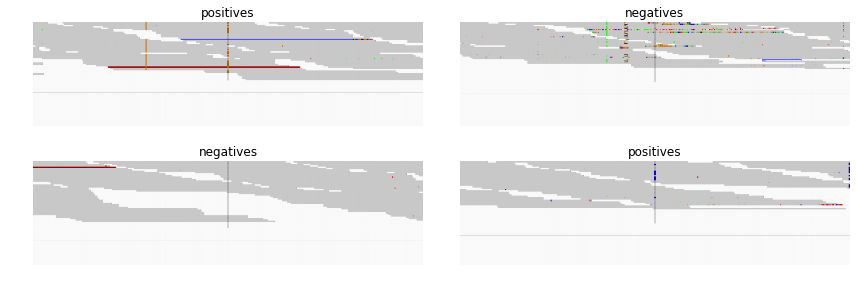

In [336]:
data.show_batch(rows=2, figsize=(12, 4))

In [337]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), #len(data.test_ds)

(['positives', 'negatives'], 2, 6750, 1687)

## Train model

In [338]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [339]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


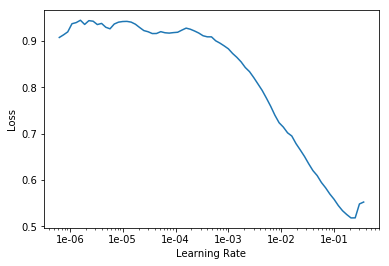

In [340]:
learn.recorder.plot()

In [341]:
learn.fit_one_cycle(2, max_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.114197,0.225783,0.972140,01:20
1,0.054434,0.023634,0.993480,01:10


In [342]:
learn.save('stage-1')

In [343]:
learn.unfreeze()

lr_find fail to run periodically, is this due to memery issue? no. it stops because the loss get much worse.

In [344]:
learn.lr_find(start_lr=1e-8, end_lr=1e-3, stop_div=False) # if stop_div=True it will stop when the loss get much worse

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


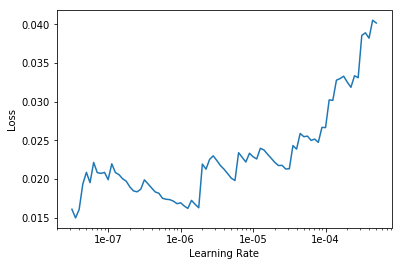

In [345]:
learn.recorder.plot()

In [266]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [346]:
learn.fit_one_cycle(2, max_lr=5e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.023404,0.018781,0.994665,01:34
1,0.020406,0.016974,0.994665,01:34


In [347]:
learn.save('stage-2')

## Interpretation

In [393]:
learn.load('stage-2');

In [395]:
interp = ClassificationInterpretation.from_learner(learn)
# acc = (interp.pred_class == interp.y_true).float().mean()
# print(f'accuracy is {acc}')

IndexError: Traceback (most recent call last):
  File "/projects/da_workspace/software/miniconda/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/projects/da_workspace/software/miniconda/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/projects/da_workspace/software/miniconda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py", line 648, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/projects/da_workspace/software/miniconda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py", line 118, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/projects/da_workspace/software/miniconda/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "/projects/da_workspace/software/miniconda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py", line 74, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0


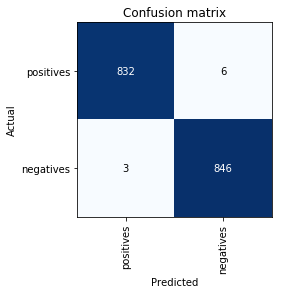

In [350]:
interp.plot_confusion_matrix()

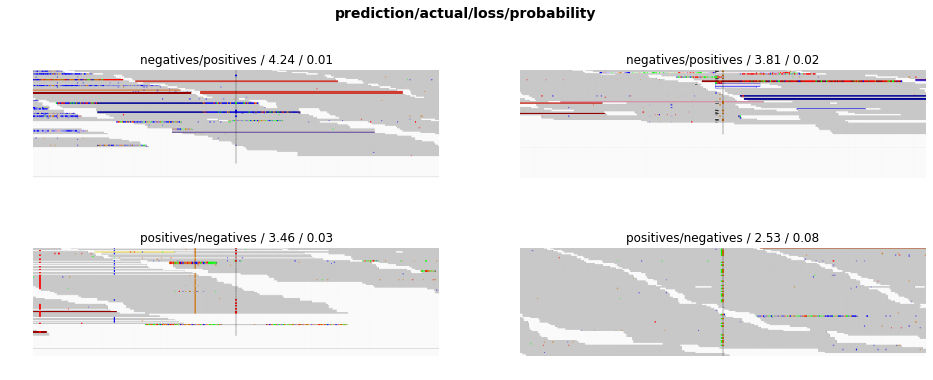

In [361]:
interp.plot_top_losses(4, heatmap=False, figsize=(16, 6))
# "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."

In [381]:
interp.ds

LabelList (1687 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
negatives,positives,positives,positives,negatives
Path: /projects/da_workspace/szspace/data/snapshots

# heatmap

Category positives

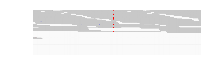

In [366]:
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [367]:
x.shape

torch.Size([3, 200, 750])

In [368]:
m = learn.model.eval();

In [371]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

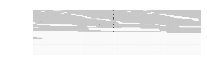

In [372]:
show_image(data.denorm(xb)[0])
# show_image(xb[0]) # normalized 

In [373]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a,hook_g

def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

torch.Size([512, 7, 24])

torch.Size([7, 24])

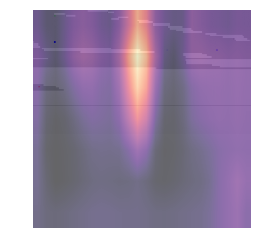

In [375]:
hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape
avg_acts = acts.mean(0)
avg_acts.shape
show_heatmap(avg_acts)

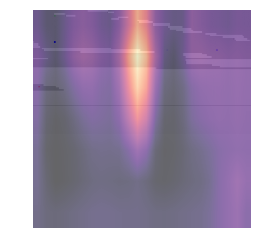

In [377]:
_,ax = plt.subplots()
xb_im.show(ax)
ax.imshow(avg_acts, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma')
of = '/projects/da_workspace/szspace/data/snapshots/models/hm.png'
plt.savefig(of, bbox_inches='tight')

# predict test set

by definition, test data set does not have labels, can I load the model and pretend the test set is validation set and get the test accuracy? yes. instead of specify val_pct, give a directory

In [392]:
ImageDataBunch.from_folder??

In [380]:
classes

['positives', 'negatives']

In [181]:
np.random.seed(42)
data_test = ImageDataBunch.from_folder(path, 
                                  train="train",
                                  valid='pog_imgs',
#                                   valid_pct=0.2, 
                                  classes=classes,
                                  ds_tfms=tfms, 
                                  size=img_sz, bs=bs, 
                                  num_workers=4).normalize(imagenet_stats)

In [182]:
data_test

ImageDataBunch;

Train: LabelList (7997 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Valid: LabelList (312 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Test: None

In [183]:
# set the model data attribute
learn.data = data_test
learn

Learner(data=ImageDataBunch;

Train: LabelList (7997 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Valid: LabelList (312 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

accuracy is 0.9230769276618958


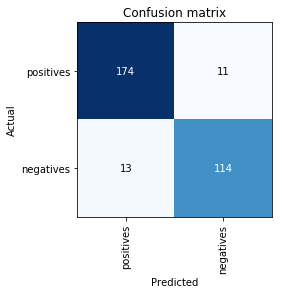

In [184]:
interp = ClassificationInterpretation.from_learner(learn)
acc = (interp.pred_class == interp.y_true).float().mean()
print(f'accuracy is {acc}')
interp.plot_confusion_matrix()

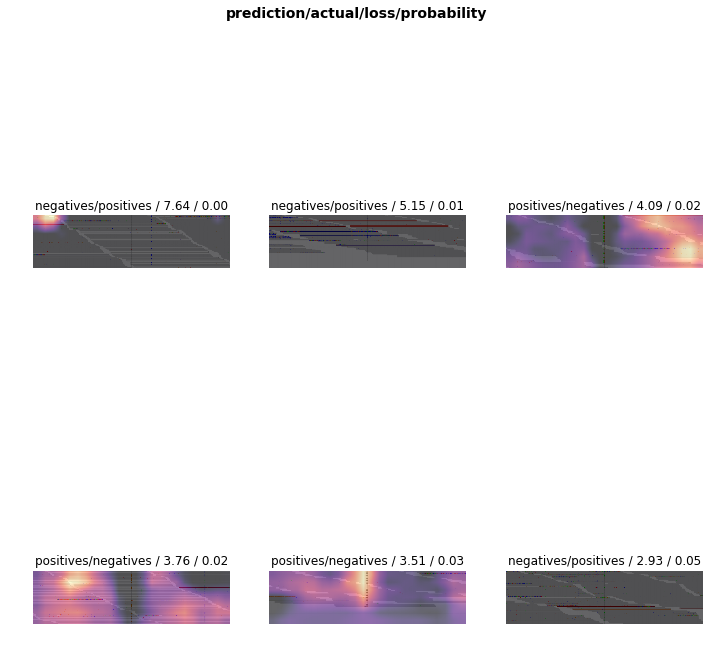

In [187]:
interp.plot_top_losses(6, heatmap=True, figsize=(16,6))

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [389]:
path
path.ls()
!ls /projects/da_workspace/szspace/data/snapshots/positives|head

PosixPath('/projects/da_workspace/szspace/data/snapshots')

[PosixPath('/projects/da_workspace/szspace/data/snapshots/negatives'),
 PosixPath('/projects/da_workspace/szspace/data/snapshots/positives'),
 PosixPath('/projects/da_workspace/szspace/data/snapshots/models'),
 PosixPath('/projects/da_workspace/szspace/data/snapshots/export.pkl')]

chr10_100,217,909_100,218,209.png
chr10_101,103,253_101,103,553.png
chr10_101,123,131_101,123,431.png
chr10_101,218,548_101,218,848.png
chr10_1,016,598_1,016,898.png
chr10_10,257,402_10,257,702.png
chr10_103,601,249_103,601,549.png
chr10_104,671,062_104,671,362.png
chr10_105,240,034_105,240,334.png
chr10_106,175,439_106,175,739.png
ls: write error: Broken pipe


In [383]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [189]:
defaults.device = torch.device('cpu')

In [190]:
path.ls()

[PosixPath('/projects/da_workspace/szspace/data/giab_imgs/models'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/hm.png'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/test.batch'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/my.ipynb'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/train'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/pog_imgs'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/export.pkl')]

In [390]:
img = open_image('/projects/da_workspace/szspace/data/snapshots/positives/chr10_101,123,131_101,123,431.png')
learn = load_learner(path)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category positives

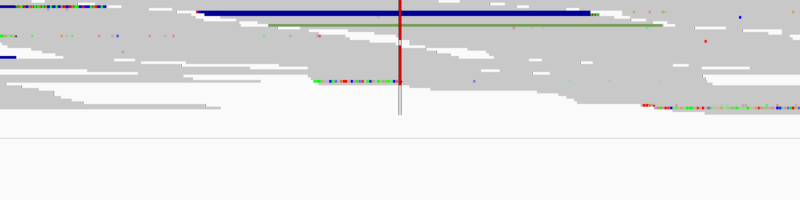

In [391]:
img

### investigate transform further to see how you can truly random crop so the position of interest varies

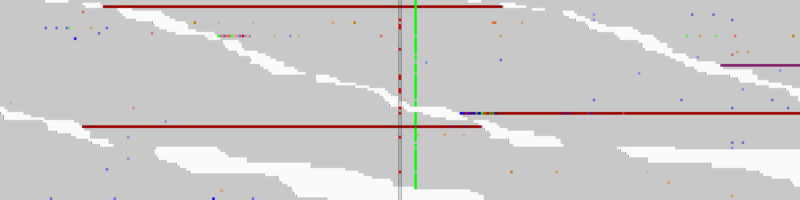

In [7]:
# it looks like this is the way to go: give a rectangular size and let the crop from top centre position (0., 0.5)
fname = '/projects/da_workspace/szspace/data/snapshots/positives/chr11_47,609,711_47,610,011.png'
open_image(fname)

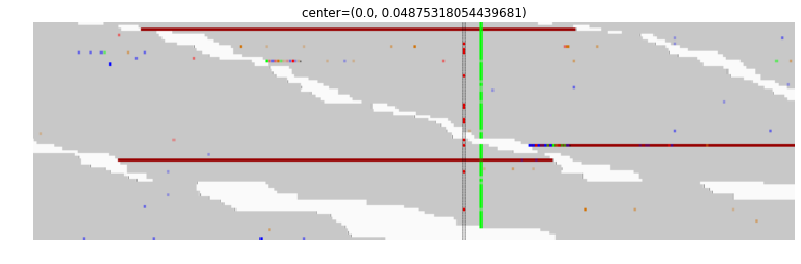

In [47]:
# this shows how you can randomly crop an image
f, ax = plt.subplots(figsize=(16,4))
center = [0., np.random.random()]
crop(open_image(fname), (200, 700), *center).show(ax=ax, title=f'center=({center[0]}, {center[1]})')

In [95]:
doc(RandTransform)

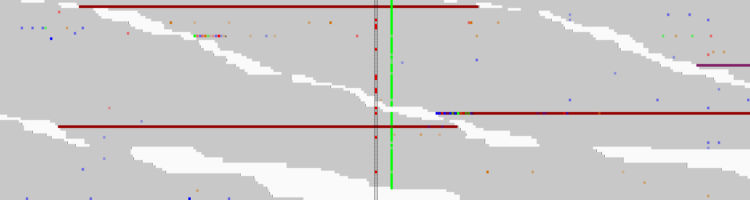

In [147]:
# this shows how you can use transformation to do data augmentation
# execute multiple times, you should see slightly different images
tfm = [crop(size=(200, 750), row_pct=0., col_pct=np.random.rand())]
open_image(fname).apply_tfms(tfm)

In [199]:
RandTransform??

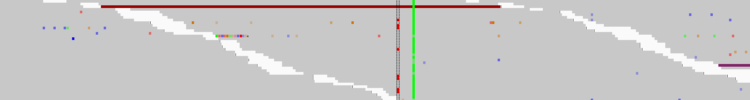

In [329]:
tfms = [RandTransform(tfm=TfmPixel (crop), kwargs={'size': (100, 750), 'row_pct': (0, 0), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]
open_image(fname).apply_tfms(tfms)

In [137]:
xtra_tfm = [crop(size=(200, 750), row_pct=0., col_pct=np.random.rand())] 
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., 
                      max_warp=None, max_lighting=None, p_affine=0, p_lighting=0,
                      xtra_tfms=xtra_tfm)

In [140]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': (200, 750), 'row_pct': 0.0, 'col_pct': 0.36121605897581177}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

# test transformations

why it is not random at all? I dont know why but restart the kernel made randomizing happen. Is it because I set random seeds before?  
ranomization does not work for rectangular images!  
also even I use the full size image, it only show part of the image after tranformation, weird.

### observe that the images are slightly different after each transformation

torch.Size([3, 200, 750])
torch.Size([3, 200, 750])
torch.Size([3, 200, 750])
torch.Size([3, 200, 750])


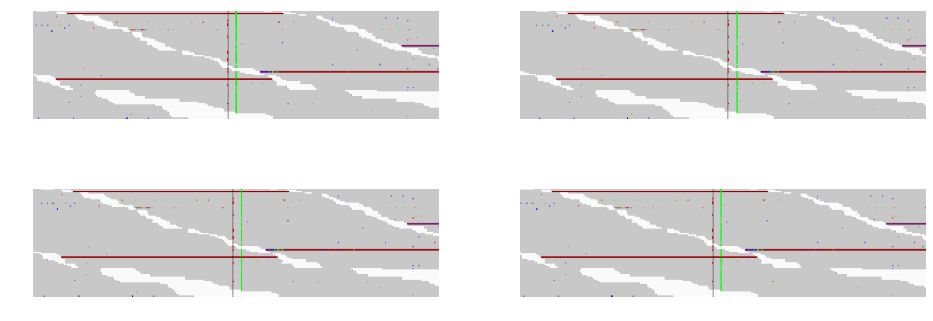

In [106]:
def get_ex(): 
    return open_image(fname)


_, axs = plt.subplots(2,2,figsize=(16,6))
for ax in axs.flatten():
    tfm = [crop(size=(200, 750), row_pct=0., col_pct=np.random.rand())]
    img = get_ex().apply_tfms(tfm)
    print(img.shape)
    img.show(ax=ax)